## Package imports

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from pandas_profiling import ProfileReport

from sklearn.preprocessing import LabelEncoder # StandardScaler

import re
import seaborn as sns
import matplotlib.pyplot as plt

import scipy.stats as st
from scipy import sparse
from scipy.sparse import hstack

import pyarrow
# import pickle

In [2]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None
%matplotlib inline

## Import data

In [3]:
data = pd.read_parquet('./input/consumer_complaints.parquet')
data.head(10)

,date_received,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zipcode,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?,complaint_id
0,08/30/2013,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",None,None,None,U.S. Bancorp,CA,95993,None,None,Referral,09/03/2013,Closed with explanation,Yes,Yes,511074
1,08/30/2013,Mortgage,Other mortgage,"Loan servicing, payments, escrow account",None,None,None,Wells Fargo & Company,CA,91104,None,None,Referral,09/03/2013,Closed with explanation,Yes,Yes,511080
2,08/30/2013,Credit reporting,None,Incorrect information on credit report,Account status,None,None,Wells Fargo & Company,NY,11764,None,None,Postal mail,09/18/2013,Closed with explanation,Yes,No,510473
3,08/30/2013,Student loan,Non-federal student loan,Repaying your loan,Repaying your loan,None,None,"Navient Solutions, Inc.",MD,21402,None,None,Email,08/30/2013,Closed with explanation,Yes,Yes,510326
4,08/30/2013,Debt collection,Credit card,False statements or representation,Attempted to collect wrong amount,None,None,Resurgent Capital Services L.P.,GA,30106,None,None,Web,08/30/2013,Closed with explanation,Yes,Yes,511067
5,08/30/2013,Credit card,None,Application processing delay,None,None,None,Capital One,NY,12206,None,None,Phone,09/03/2013,Closed with explanation,Yes,Yes,510098
6,08/30/2013,Credit card,None,Credit line increase/decrease,None,None,None,Wells Fargo & Company,AZ,85730,None,None,Postal mail,09/05/2013,Closed with explanation,Yes,No,511062
7,08/30/2013,Bank account or service,Checking account,Deposits and withdrawals,None,None,None,Bank of America,IL,60660,None,None,Referral,09/04/2013,Closed with explanation,Yes,No,511116
8,08/30/2013,Bank account or service,Checking account,Deposits and withdrawals,None,None,None,Bank of America,GA,30016,None,None,Referral,09/04/2013,Closed with explanation,Yes,No,511091
9,09/17/2013,Mortgage,Conventional adjustable mortgage (ARM),"Loan modification,collection,foreclosure",None,None,None,"SunTrust Banks, Inc.",CA,94551,None,None,Web,09/18/2013,Closed with explanation,Yes,Yes,530602


In [39]:
# save data to df so won't have to reload data if need to start over with df.
df = data.copy()

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555957 entries, 0 to 555956
Data columns (total 18 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   date_received                 555957 non-null  object
 1   product                       555957 non-null  object
 2   sub_product                   397635 non-null  object
 3   issue                         555957 non-null  object
 4   sub_issue                     212622 non-null  object
 5   consumer_complaint_narrative  66806 non-null   object
 6   company_public_response       85124 non-null   object
 7   company                       555957 non-null  object
 8   state                         551070 non-null  object
 9   zipcode                       551452 non-null  object
 10  tags                          77959 non-null   object
 11  consumer_consent_provided     123458 non-null  object
 12  submitted_via                 555957 non-null  object
 13 

In [41]:
df.shape

(555957, 18)

In [42]:
list(df.columns)

['date_received',
 'product',
 'sub_product',
 'issue',
 'sub_issue',
 'consumer_complaint_narrative',
 'company_public_response',
 'company',
 'state',
 'zipcode',
 'tags',
 'consumer_consent_provided',
 'submitted_via',
 'date_sent_to_company',
 'company_response_to_consumer',
 'timely_response',
 'consumer_disputed?',
 'complaint_id']

In [43]:
# Only keep records with a complaint narrative for NLP
# Will reduce dataset from half million to ~67k which is still well sized 
df = df[~df['consumer_complaint_narrative'].isnull()].reset_index(drop=True)

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66806 entries, 0 to 66805
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   date_received                 66806 non-null  object
 1   product                       66806 non-null  object
 2   sub_product                   46351 non-null  object
 3   issue                         66806 non-null  object
 4   sub_issue                     32932 non-null  object
 5   consumer_complaint_narrative  66806 non-null  object
 6   company_public_response       32776 non-null  object
 7   company                       66806 non-null  object
 8   state                         66620 non-null  object
 9   zipcode                       66617 non-null  object
 10  tags                          11417 non-null  object
 11  consumer_consent_provided     66806 non-null  object
 12  submitted_via                 66806 non-null  object
 13  date_sent_to_com

In [45]:
df.head()

,date_received,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zipcode,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?,complaint_id
0,03/19/2015,Debt collection,"Other (i.e. phone, health club, etc.)",Cont'd attempts collect debt not owed,Debt was paid,XXXX has claimed I owe them {$27.00} for XXXX ...,None,"Diversified Consultants, Inc.",NY,121XX,Older American,Consent provided,Web,03/19/2015,Closed with explanation,Yes,No,1290516
1,03/19/2015,Consumer Loan,Vehicle loan,Managing the loan or lease,None,Due to inconsistencies in the amount owed that...,None,M&T Bank Corporation,VA,221XX,Servicemember,Consent provided,Web,03/19/2015,Closed with explanation,Yes,No,1290492
2,03/19/2015,Mortgage,Conventional fixed mortgage,"Loan modification,collection,foreclosure",None,In XX/XX/XXXX my wages that I earned at my job...,None,Wells Fargo & Company,CA,946XX,None,Consent provided,Web,03/19/2015,Closed with explanation,Yes,Yes,1290524
3,03/19/2015,Mortgage,Conventional fixed mortgage,"Loan servicing, payments, escrow account",None,I have an open and current mortgage with Chase...,None,JPMorgan Chase & Co.,CA,900XX,Older American,Consent provided,Web,03/19/2015,Closed with explanation,Yes,Yes,1290253
4,03/19/2015,Mortgage,Conventional fixed mortgage,Credit decision / Underwriting,None,XXXX was submitted XX/XX/XXXX. At the time I s...,None,Rushmore Loan Management Services LLC,CA,956XX,Older American,Consent provided,Web,03/19/2015,Closed with explanation,Yes,Yes,1292137


## Explore dataset with pandas profiling
- ### Quick way to look at distributions, find missing values, etc.

In [46]:
profile = ProfileReport(df, title="Consumer Complaints EDA Profiling Report")
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [47]:
# save EDA profile report 
profile.to_file("./EDA_outputs/Consumer Complaints EDA Profiling Report.html")

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## Summary of dataset profile report findings:

- #### date_received: categorical, no missing values, convert to datetime
- #### product: TARGET! categorical, no missing values, convert with LabelEncoder()
- #### sub_product: categorical, missing 30.6% of values, (target/freq) encoding with potential flag variables for low-occurring and missing
- #### issue: categorical, no missing values, (target/freq) encoding with potential flag variable for low-occurring
- #### sub_issue: categorical, missing 50.7% of values, DROP or (target/freq) encoding with potential flag variables for low-occurring and missing
- #### consumer_complaint_narrative: TEXT, no missing values, various NLP methodologies and potential flag variable for low-occurring but duplicate narratives
- #### company_public_response: categorical, missing 50.9% of values, DROP or (target/freq) encoding with potential flag variable for missing
- #### company: categorical, no missing values, (target/freq) encoding with potential flag variable for low-occurring
- #### state: categorical, missing 0.3% of values, (target/freq) encoding with potential flag variables for low-occurring and missing
- #### zipcode: categorical (slightly ordinal), missing 0.3% of values, (target/freq) or label encoding with potential flag variables for low-occurring and missing
- #### tags: categorical, missing 82.9% of values, Don't drop because missing is taken as non servicemember and not older - one-hot or label encoding including flag variable for missing
- #### consumer_consent_provided: categorical, no missing values, DROP because univariate (consent always provided for this dataset)
- #### submitted_via: categorical, no missing values, DROP because univariate (all submissions via web)
- #### date_sent_to_company: categorical, no missing values, convert to datetime
- #### company_response_to_consumer: categorical, no missing values, one-hot or label encoding with potential flag variable for low-occurring
- #### timely_response: boolean, no missing values, binary encode
- #### consumer_disputed?: boolean, no missing values, binary encode
- #### complaint_id: complaint identifier index, not needed


## Drop univariate variables

In [48]:
df = df.drop(['consumer_consent_provided', 'submitted_via'], axis=1)

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66806 entries, 0 to 66805
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   date_received                 66806 non-null  object
 1   product                       66806 non-null  object
 2   sub_product                   46351 non-null  object
 3   issue                         66806 non-null  object
 4   sub_issue                     32932 non-null  object
 5   consumer_complaint_narrative  66806 non-null  object
 6   company_public_response       32776 non-null  object
 7   company                       66806 non-null  object
 8   state                         66620 non-null  object
 9   zipcode                       66617 non-null  object
 10  tags                          11417 non-null  object
 11  date_sent_to_company          66806 non-null  object
 12  company_response_to_consumer  66806 non-null  object
 13  timely_response 

In [50]:
df.head()

,date_received,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zipcode,tags,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?,complaint_id
0,03/19/2015,Debt collection,"Other (i.e. phone, health club, etc.)",Cont'd attempts collect debt not owed,Debt was paid,XXXX has claimed I owe them {$27.00} for XXXX ...,None,"Diversified Consultants, Inc.",NY,121XX,Older American,03/19/2015,Closed with explanation,Yes,No,1290516
1,03/19/2015,Consumer Loan,Vehicle loan,Managing the loan or lease,None,Due to inconsistencies in the amount owed that...,None,M&T Bank Corporation,VA,221XX,Servicemember,03/19/2015,Closed with explanation,Yes,No,1290492
2,03/19/2015,Mortgage,Conventional fixed mortgage,"Loan modification,collection,foreclosure",None,In XX/XX/XXXX my wages that I earned at my job...,None,Wells Fargo & Company,CA,946XX,None,03/19/2015,Closed with explanation,Yes,Yes,1290524
3,03/19/2015,Mortgage,Conventional fixed mortgage,"Loan servicing, payments, escrow account",None,I have an open and current mortgage with Chase...,None,JPMorgan Chase & Co.,CA,900XX,Older American,03/19/2015,Closed with explanation,Yes,Yes,1290253
4,03/19/2015,Mortgage,Conventional fixed mortgage,Credit decision / Underwriting,None,XXXX was submitted XX/XX/XXXX. At the time I s...,None,Rushmore Loan Management Services LLC,CA,956XX,Older American,03/19/2015,Closed with explanation,Yes,Yes,1292137


## Explore target value and transform with LabelEncoder

In [51]:
product = df['product'].value_counts()
print(product)

Debt collection            17552
Mortgage                   14919
Credit reporting           12526
Credit card                 7929
Bank account or service     5711
Consumer Loan               3678
Student loan                2128
Prepaid card                 861
Payday loan                  726
Money transfers              666
Other financial service      110
Name: product, dtype: int64


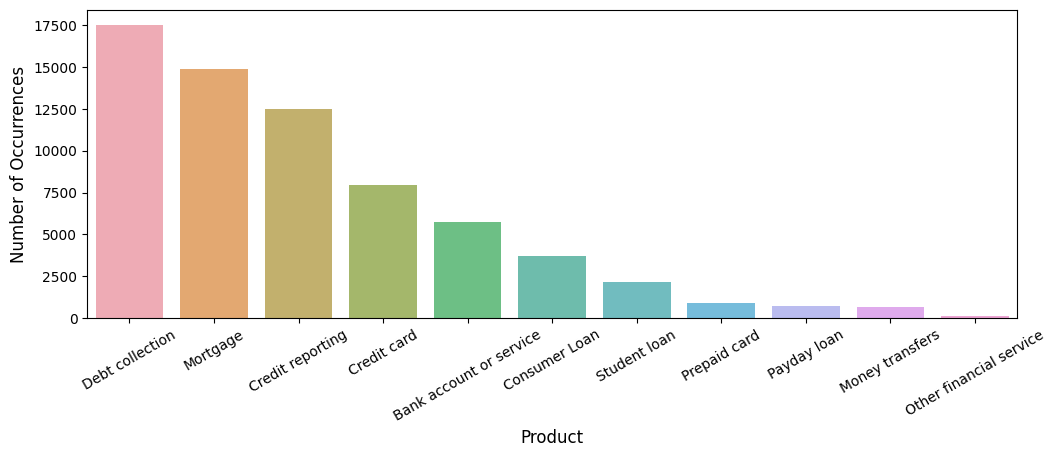

In [52]:
plt.figure(figsize=(12,4))
sns.barplot(x=product.index, y=product.values, alpha=0.8) 
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Product', fontsize=12)
plt.xticks(rotation=30)
plt.show()

In [53]:
df['label'] = LabelEncoder().fit_transform(df['product'])

## Convert date values with datetime and create new feature for time between date_received and date_sent_to_company 

In [54]:
# Vectorized operation to convert date string to datetime object
# "exact=False" argument used because of errant whitespaces (i.e. /n)
df['date_received'] = np.where(
    pd.isna(df['date_received']) == False,
    pd.to_datetime(df['date_received'], format='%m/%d/%Y', exact=False).dt.date,
    None
)

In [55]:
# Vectorized operation to convert date string to datetime object
# "exact=False" argument used because of errant whitespaces (i.e. /n)
df['date_sent_to_company'] = np.where(
    pd.isna(df['date_sent_to_company']) == False,
    pd.to_datetime(df['date_sent_to_company'], format='%m/%d/%Y', exact=False).dt.date,
    None
)

In [56]:
# Create new feature that is the difference in days between when a complaint was received and when it was sent to company
df['days_between_receipt_and_sent'] = np.where(
    (pd.isna(df['date_received']) == False) & (pd.isna(df['date_sent_to_company']) == False),
    (df['date_sent_to_company'] - df['date_received']).dt.days,
    None
)

In [57]:
# Change new feature from datetime object to integer
df['days_between_receipt_and_sent'] = pd.to_numeric(df['days_between_receipt_and_sent'])

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66806 entries, 0 to 66805
Data columns (total 18 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   date_received                  66806 non-null  object
 1   product                        66806 non-null  object
 2   sub_product                    46351 non-null  object
 3   issue                          66806 non-null  object
 4   sub_issue                      32932 non-null  object
 5   consumer_complaint_narrative   66806 non-null  object
 6   company_public_response        32776 non-null  object
 7   company                        66806 non-null  object
 8   state                          66620 non-null  object
 9   zipcode                        66617 non-null  object
 10  tags                           11417 non-null  object
 11  date_sent_to_company           66806 non-null  object
 12  company_response_to_consumer   66806 non-null  object
 13  t

In [59]:
df.head()

,date_received,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zipcode,tags,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?,complaint_id,label,days_between_receipt_and_sent
0,2015-03-19,Debt collection,"Other (i.e. phone, health club, etc.)",Cont'd attempts collect debt not owed,Debt was paid,XXXX has claimed I owe them {$27.00} for XXXX ...,None,"Diversified Consultants, Inc.",NY,121XX,Older American,2015-03-19,Closed with explanation,Yes,No,1290516,4,0
1,2015-03-19,Consumer Loan,Vehicle loan,Managing the loan or lease,None,Due to inconsistencies in the amount owed that...,None,M&T Bank Corporation,VA,221XX,Servicemember,2015-03-19,Closed with explanation,Yes,No,1290492,1,0
2,2015-03-19,Mortgage,Conventional fixed mortgage,"Loan modification,collection,foreclosure",None,In XX/XX/XXXX my wages that I earned at my job...,None,Wells Fargo & Company,CA,946XX,None,2015-03-19,Closed with explanation,Yes,Yes,1290524,6,0
3,2015-03-19,Mortgage,Conventional fixed mortgage,"Loan servicing, payments, escrow account",None,I have an open and current mortgage with Chase...,None,JPMorgan Chase & Co.,CA,900XX,Older American,2015-03-19,Closed with explanation,Yes,Yes,1290253,6,0
4,2015-03-19,Mortgage,Conventional fixed mortgage,Credit decision / Underwriting,None,XXXX was submitted XX/XX/XXXX. At the time I s...,None,Rushmore Loan Management Services LLC,CA,956XX,Older American,2015-03-19,Closed with explanation,Yes,Yes,1292137,6,0
